# Node2Vec Implementation
### Yonsei App. Stat
### Sunwoo Kim

## 0. Import Data

Karater Club 데이터를 불러오고,   
Py 파일로 구현된 Node2Vec을 불러옵니다.

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys 
import networkx as nx 
from sunwoo_node2vec import *

In [3]:
a = []
with open('karate_club.adjlist') as f : 
    for line in f : 
        a.append(line.rstrip().split())
a = a[3:]
adj_array = np.zeros(len(a)*len(a)).reshape(len(a), len(a))

for i1 in a : 
    for i2 in range(len(i1)) : 
        index1 = int(i1[0]) ; index2 = int(i1[i2])
        adj_array[index1, index2] = 1

adj_half = adj_array
adj_array = adj_array + adj_array.transpose()

for i in range(adj_array.shape[0]) : adj_array[i,i] = 0
for i in range(adj_half.shape[0]) : adj_half[i,i] = 0

## 현재 Edge Index가 adj_array에 할당된 상태입니다

target = []
with open('karate_label.txt') as f : 
    for line in f : 
        target.append(int(line.rstrip().split()[1]))

red = np.where(np.array(target) == 1)[0] + 1
green = np.where(np.array(target) == 0)[0] + 1

## 색깔별 노드의 class를 할당해줍니다.

시각화를 위한 plot입니다.

In [7]:
def visualize_result (embedding_result, targets, title) :
    """
    param: embedding_result = W Matrix
    param: targets = target labels
    """
    plt.figure(figsize = (7, 7))
    plt.title(title)
    color_list = ['lime', 'red']
    for i in range(34) : 
        target_ = targets[i]
        plt.scatter(embedding_result[i,0], embedding_result[i,1], color = color_list[target_])
    for i, txt in enumerate(np.arange(1,35)):
        plt.annotate((i + 1), (embedding_result[:, 0][i], embedding_result[:, 1][i]), size = 15)
    plt.show()
    name = title + ".PNG"
    plt.savefig(name, format = 'PNG')

Number of Node is 34
Number of Edge is 78


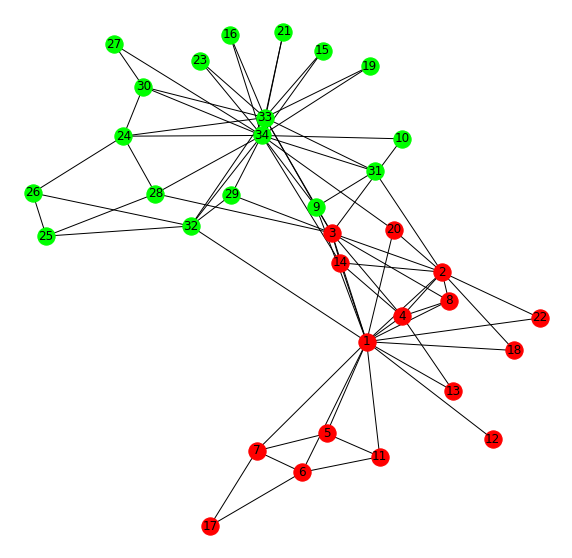

In [4]:
G = nx.Graph()
for i in range(np.where(adj_half > 0)[0].shape[0]) : 
    G.add_edge(np.where(adj_half > 0)[0][i] + 1, 
                    np.where(adj_half > 0)[1][i] + 1)
print("Number of Node is", G.number_of_nodes())
print("Number of Edge is", G.number_of_edges())

plt.figure(figsize = (10,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, 
                      nodelist = list(red), 
                      node_color = 'red')

nx.draw_networkx_nodes(G, pos,
                      nodelist = list(green), 
                      node_color = 'lime')
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos, font_size=12)
plt.axis("off")
plt.savefig("Karate_Graph.png", format="PNG")

## 1. Node2Vec Implementation

레미제라블 네트워크와 유사하게,  
- p = 1 / q = 2
- p = 1 / q = 0.5  
인 두 모델을 구현해봅시다.

In [5]:
model_p1q2 = node2vec(adj_array)
model_p1q0_5 = node2vec(adj_array)

---------

### 1.1. Microscopic / Structural Equivalence / p = 1 & q = 2

Training Started!
Learning Finshed in 0.7831759452819824 seconds


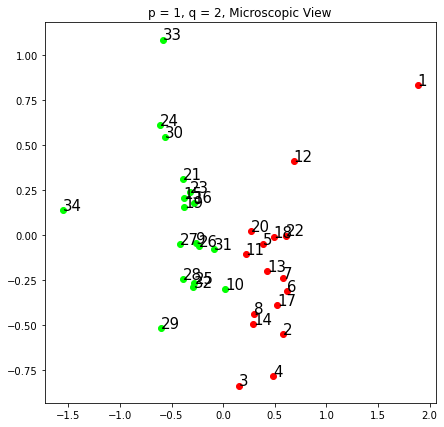

<Figure size 432x288 with 0 Axes>

In [39]:
model_p1q2.fit(k = 2, init_method = 'normal', 
          var = 0.1, p = 1, q = 2,
          epochs = 10,
          walk_length = 6,
          window_size = 2,
          lr = 0.02,
          neg_sample = 3)

visualize_result(model_p1q2.h, target, 'p = 1, q = 2, Microscopic View')

Structural Role의 영향을 받았는가 확인해보겠습니다.  
- 13, 18, 22의 경우 직접적 연결이 없으나 비슷한 Role에 놓여있는 부분에서 가깝게 임베딩 되었습니다. 
- 그 외 부분적으로 이러한 특성이 반영되었으나, 허브에 해당하는 1, 33, 34가 가까이 위치되지 않은 부분이 한계로 남습니다.

--------

### 1.2. Macroscopic / Community / p = 1 & q = 0.5

Training Started!
Learning Finshed in 0.7851762771606445 seconds


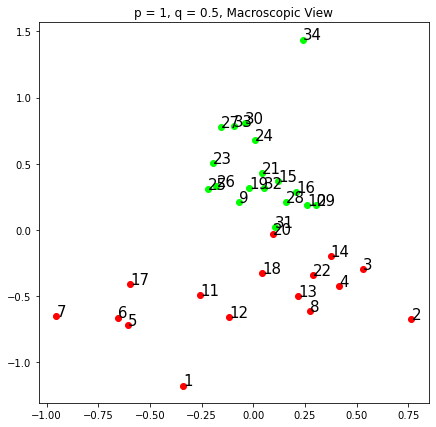

<Figure size 432x288 with 0 Axes>

In [42]:
model_p1q0_5.fit(k = 2, init_method = 'normal', 
          var = 0.1, p = 1, q = 0.5,
          epochs = 10,
          walk_length = 6,
          window_size = 2,
          lr = 0.02,
          neg_sample = 3)

visualize_result(model_p1q0_5.h, target, 'p = 1, q = 0.5, Macroscopic View')

Community의 영향을 받았는가 확인해보겠습니다.  
- 접경지역에 해당하는 20 / 31번 노드가 각각 경계선에 임베딩 되었습니다.
- 그 외 색깔별로 임베딩이 된 것을 확인할 수 있습니다.
- 그러나 이번에도 허브인 1번과 34번 노드가 외곽에 위치한 점이 한계로 남습니다.